In [1]:
import pandas as pd
from notebooks.consts import *

csv_path = NOTEBOOK_PATH / 'data' / 'data_asoptimizer_updated.csv'
all_data = pd.read_csv(str(csv_path), low_memory=False)

In [2]:
from notebooks.notebook_utils import log_correction, get_unique_human_genes

# Remove rows with missing values in the INHIBITION column
all_data_no_nan = all_data.dropna(subset=[INHIBITION]).copy()
# Create a new column with transformed inhibition values on a negative log scale
log_correction(all_data_no_nan)  # to avoid log 0
genes_u = get_unique_human_genes(all_data_no_nan)

In [3]:
from notebooks.notebook_utils import read_cached_gene_to_data

gene_to_data = read_cached_gene_to_data(genes_u)

In [4]:
from tauso.new_model.data_handling import get_populated_df_with_structure_features

# Filter the data to include only rows where the cell line organism is human
all_data_no_nan_human = all_data_no_nan[all_data_no_nan[CELL_LINE_ORGANISM] == 'human']

# Filter data to keep only rows with valid gene information
all_data_human_gene = all_data_no_nan_human[all_data_no_nan_human[CANONICAL_GENE].isin(genes_u)].copy()

all_data_human_gene = get_populated_df_with_structure_features(all_data_human_gene, genes_u, gene_to_data)

In [5]:
import os
import subprocess
import tempfile
import pandas as pd
from tqdm import tqdm
from notebooks.consts import CANONICAL_GENE, SEQUENCE

# --- Configuration ---
MIRANDA_EXEC = "miranda"
MIRANDA_SCORE_THRESHOLD = "50.0"
MIRANDA_ENERGY_THRESHOLD = "0.0"

def get_populated_df_with_miranda_features(df, gene_to_data, aso_seq_col=SEQUENCE):
    """
    Populates the DataFrame with miRanda scores and energy values.
    Progress is tracked per ASO sequence.

    Args:
        df (pd.DataFrame): The dataframe containing ASO data.
        gene_to_data (dict): Dictionary mapping gene IDs to gene objects.
        aso_seq_col (str): The column name for ASO sequences (variable from consts).

    Returns:
        pd.DataFrame: A copy of df with 'miranda_score' and 'miranda_energy' columns added.
    """
    df_out = df.copy()

    # Initialize columns
    df_out['miranda_score'] = 0.0
    df_out['miranda_energy'] = 0.0

    # Group by Gene to process in batches, but track progress by total sequences
    # Groupby is also faster than filtering the DF inside a loop
    grouped = df_out.groupby(CANONICAL_GENE)

    print(f"Starting miRanda analysis on {len(df_out)} sequences...")

    with tempfile.TemporaryDirectory() as temp_dir:

        # Initialize progress bar with TOTAL number of rows (sequences)
        with tqdm(total=len(df_out), desc="Processing Sequences") as pbar:

            for gene_id, gene_subset in grouped:

                # Update progress bar by the number of ASOs in this gene group
                # We do this at the start so even skipped genes count towards 'processed' (ignored)
                pbar.update(len(gene_subset))

                # 1. Retrieve Target Sequence
                if gene_id not in gene_to_data:
                    continue

                target_seq = gene_to_data[gene_id].full_mrna

                if not target_seq:
                    continue

                # 2. Create Target FASTA
                target_fasta_path = os.path.join(temp_dir, "target.fa")
                with open(target_fasta_path, "w") as f:
                    f.write(f">{gene_id}\n{target_seq}\n")

                # 3. Create ASOs FASTA (Batch)
                # We use the DataFrame Index as the identifier
                aso_fasta_path = os.path.join(temp_dir, "asos.fa")
                with open(aso_fasta_path, "w") as f:
                    for idx, row in gene_subset.iterrows():
                        if pd.notna(row[aso_seq_col]):
                            f.write(f">{idx}\n{row[aso_seq_col]}\n")

                # 4. Run miRanda
                output_path = os.path.join(temp_dir, "miranda_out.txt")
                cmd = [
                    MIRANDA_EXEC,
                    aso_fasta_path,
                    target_fasta_path,
                    "-sc", MIRANDA_SCORE_THRESHOLD,
                    "-en", MIRANDA_ENERGY_THRESHOLD,
                    "-out", output_path,
                    "-strict"
                ]

                try:
                    subprocess.run(cmd, check=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
                except (subprocess.CalledProcessError, FileNotFoundError):
                    continue

                # 5. Parse Results
                best_hits = {}

                if os.path.exists(output_path):
                    with open(output_path, 'r') as f:
                        for line in f:
                            if line.startswith('>'):
                                parts = line.strip().split()
                                if len(parts) >= 4:
                                    try:
                                        # Extract Index: ">123" -> 123
                                        idx = int(parts[0][1:])
                                        score = float(parts[2])
                                        energy = float(parts[3])

                                        # Keep the Lowest Energy (strongest binding)
                                        if idx in best_hits:
                                            curr_score, curr_energy = best_hits[idx]
                                            if energy < curr_energy:
                                                best_hits[idx] = (score, energy)
                                        else:
                                            best_hits[idx] = (score, energy)

                                    except ValueError:
                                        continue

                # 6. Update Main DataFrame
                # We update specific indices based on the parsing results
                for idx, (score, energy) in best_hits.items():
                    df_out.at[idx, 'miranda_score'] = score
                    df_out.at[idx, 'miranda_energy'] = energy

    return df_out


In [6]:

# ==========================================
# Execution
# ==========================================

all_data_human_gene = get_populated_df_with_miranda_features(
    all_data_human_gene,
    gene_to_data
)

Starting miRanda analysis on 31000 sequences...


Processing Sequences: 100%|██████████| 31000/31000 [4:54:41<00:00,  1.75it/s]


In [7]:
from notebooks.features.feature_extraction import save_feature

save_feature(all_data_human_gene, 'miranda_score')

In [10]:
save_feature(all_data_human_gene, 'miranda_energy')

/tmp/ipykernel_1633459/4047399779.py:23: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, p_val = spearmanr(group[FEATURE_COL], group[INHIBITION_COL])
/tmp/ipykernel_1633459/4047399779.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


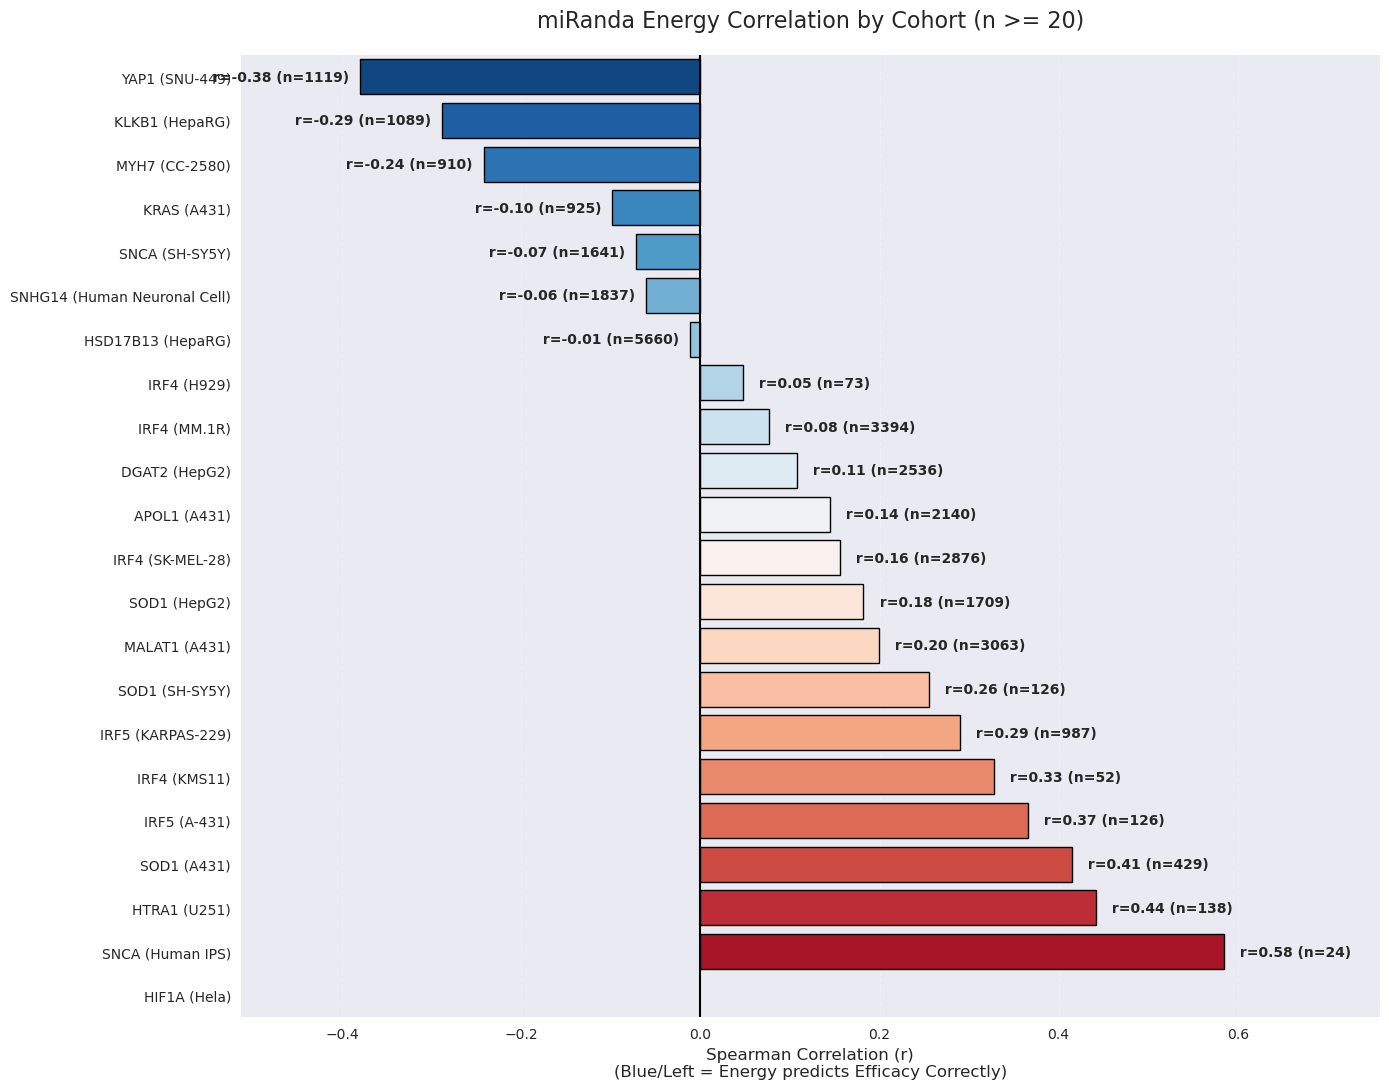

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from notebooks.consts import CANONICAL_GENE, INHIBITION

# --- CONFIGURATION ---
MIN_SAMPLES = 20
INHIBITION_COL = INHIBITION
FEATURE_COL = 'miranda_energy'  # Ensure this matches your column name
# ---------------------

# 1. Prepare Data
df_analysis = all_data_human_gene.dropna(subset=[INHIBITION_COL, FEATURE_COL]).copy()
df_analysis['Cohort'] = df_analysis[CANONICAL_GENE] + " (" + df_analysis['Cell_line'] + ")"

# 2. Calculate Correlation
cohort_stats = []
for cohort, group in df_analysis.groupby('Cohort'):
    if len(group) < MIN_SAMPLES: continue

    # Calculate Spearman (Negative r is GOOD for Energy)
    corr, p_val = spearmanr(group[FEATURE_COL], group[INHIBITION_COL])
    cohort_stats.append({
        'Cohort': cohort,
        'Spearman_r': corr,
        'Count': len(group)
    })

df_stats = pd.DataFrame(cohort_stats).sort_values('Spearman_r')

# 3. Visualization (Fixed Layout)
if not df_stats.empty:
    # Taller figure to prevent squishing
    plt.figure(figsize=(14, max(8, len(df_stats) * 0.5)))

    # Draw Bar Plot
    ax = sns.barplot(
        data=df_stats,
        x='Spearman_r',
        y='Cohort',
        palette='RdBu_r',
        edgecolor='black',
        saturation=1
    )

    plt.axvline(x=0, color='black', linewidth=1.5, linestyle='-')

    # --- FIX: Add padding to x-axis so text fits ---
    # Get current limits and expand them by 15%
    x_min, x_max = ax.get_xlim()
    ax.set_xlim(x_min * 1.2, x_max * 1.2)

    # Annotate bars
    for i, p in enumerate(ax.patches):
        val = df_stats.iloc[i]['Spearman_r']
        count = df_stats.iloc[i]['Count']

        # Smart Labeling:
        # If val is negative (left), put text to the left of the bar
        # If val is positive (right), put text to the right
        ha = 'right' if val < 0 else 'left'
        offset = -8 if val < 0 else 8

        ax.annotate(f" r={val:.2f} (n={count})",
                    (val, p.get_y() + p.get_height()/2),
                    va='center', ha=ha,
                    fontsize=10, fontweight='bold',
                    xytext=(offset, 0),
                    textcoords='offset points')

    plt.title(f"miRanda Energy Correlation by Cohort (n >= {MIN_SAMPLES})", fontsize=16, pad=20)
    plt.xlabel("Spearman Correlation (r)\n(Blue/Left = Energy predicts Efficacy Correctly)", fontsize=12)
    plt.ylabel("") # Remove y-label to save space

    # Clean up spines for a pro look
    sns.despine(left=True, bottom=True)
    plt.grid(axis='x', alpha=0.3, linestyle='--')

    # --- FIX: Prevent cutting off labels ---
    plt.tight_layout()
    plt.show()

else:
    print("No cohorts met the criteria.")